Задание - Обучите нейронную сеть любой архитектуры на каком-то производственном датасете. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети.
Можно сегментацию по Северстали.

В конце, обязательно подвести вывод.

Часто для задач сегментации используется модель сети U-Net, её и буду использовать. Производственный датасет - СЕВЕРСТАЛЬ из 4 семинара

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from multiprocessing.pool import ThreadPool
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation
from keras.metrics import MeanIoU
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
# Загрузка данных
path = 'C:\\SeverSteel\\'
data_path = path + 'train.csv'
images_dir = path + 'train_images\\'
df = pd.read_csv(data_path)
input_shape = (256, 256)  

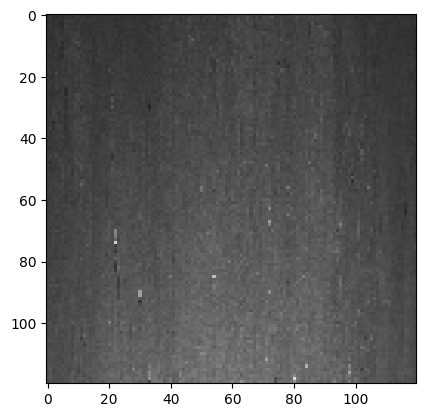

In [3]:
# Проверим что данные загружены нормально
image=cv2.imread(images_dir +'000a4bcdd.jpg',cv2.IMREAD_COLOR)
image=cv2.resize(image,(120,120))
plt.imshow(image)

In [4]:
df.shape

(7095, 3)

In [5]:
num_classes = 4  # Количество классов дефектов

In [6]:
# Функция для преобразования RLE в маску
def rle_to_mask(rle_string, height, width):
    rows, cols = height, width
    img = np.zeros(rows * cols, dtype=np.uint8)
    if rle_string is not None:
        rle_numbers = [int(numstring) for numstring in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1, 2)
        for index, length in rle_pairs:
            index -= 1
            img[index:index + length] = 1
    img = img.reshape(cols, rows)
    img = img.T
    return img

In [7]:
# Функция для построения масок
def build_masks(df, input_shape):
    height, width = input_shape

    # Инициализация массива масок с нулями для каждого класса дефекта
    
    masks = np.zeros((height, width, num_classes), dtype=np.uint8)
    for idx, row in df.iterrows():
        class_id = row['ClassId']
        rle = row['EncodedPixels']
        mask = rle_to_mask(rle, height, width)
        masks[:, :, class_id - 1] = mask  # class_id - 1 для получения правильного индекса
    return masks

In [8]:
# Функция для загрузки и предобработки изображений и масок

def preprocess_data_concurrent(df, images_dir, input_shape):
    def load_and_preprocess(img_id):
        img_path = os.path.join(images_dir, img_id)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, input_shape)
        mask = build_masks(df[df['ImageId'] == img_id], input_shape)
        return img, mask

    unique_img_ids = df['ImageId'].unique()
    with ThreadPool() as pool:
        results = pool.map(load_and_preprocess, unique_img_ids)

    images, masks = zip(*results)
    return np.array(images, dtype=np.float32) / 255.0, np.array(masks, dtype=np.float32)

Подготовка завершена, создаем и обучаем модель

In [9]:
# Функция сверточного блока

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x) 
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [10]:
# Функция для создания модели U-Net
filters = 32

def unet_model(input_size=(256, 256, 3), num_classes=4):
    inputs = Input(input_size)

    # Сверточные блоки
    conv1 = conv_block(inputs, filters)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(pool1, filters)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(pool2, filters)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(pool3, filters)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Средний слой
    conv5 = conv_block(pool4, filters)

    # Декодирующие блоки
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = conv_block(up6, filters)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = conv_block(up7, filters)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = conv_block(up8, filters)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = conv_block(up9, filters)

    # Выходной слой
    conv_final = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv_final])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [11]:
# Вызов функции для загрузки и предобработки изображений и масок
images, masks = preprocess_data_concurrent(df, images_dir, input_shape)

In [12]:
# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.1, random_state=42)

In [13]:
# Создание модели U-Net
unet = unet_model(input_size=(256, 256, 3), num_classes=4)
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,248 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][

 Total params: 197,412 (771.14 KB)

 Trainable params: 196,260 (766.64 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [14]:
# Метрика для оценки модели

num_classes = 4
IOU = MeanIoU(num_classes=num_classes)

# Компиляция модели с добавленной метрикой IoU
unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', IOU])

In [15]:
# Callbacks

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint('best_unet.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
]

In [16]:
# Обучение модели
history = unet.fit(X_train, y_train, batch_size=8, epochs=5, callbacks=callbacks, validation_data=(X_val, y_val)) 
# Установлено всего пять эпох, для демонстрации, так как модель обучается долго.

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.0919 - loss: 0.0593 - mean_io_u: 0.4939
Epoch 1: val_loss improved from inf to 0.04472, saving model to best_unet.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 626s 815ms/step - accuracy: 0.0919 - loss: 0.0593 - mean_io_u: 0.4939 - val_accuracy: 0.0345 - val_loss: 0.0447 - val_mean_io_u: 0.4949 - learning_rate: 0.0010
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.0557 - loss: 0.0541 - mean_io_u: 0.4940
Epoch 2: val_loss did not improve from 0.04472
750/750 ━━━━━━━━━━━━━━━━━━━━ 602s 803ms/step - accuracy: 0.0558 - loss: 0.0541 - mean_io_u: 0.4940 - val_accuracy: 0.7775 - val_loss: 0.0480 - val_mean_io_u: 0.4949 - learning_rate: 0.0010
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.0470 - loss: 0.0545 - mean_io_u: 0.4938
Epoch 3: val_loss improved from 0.04472 to 0.04233, saving model to best_unet.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 602s 802ms/step - accuracy: 0.0470 - loss: 0.0545 - mean_io_u

Анализ обучения

In [19]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')
    plt.show()

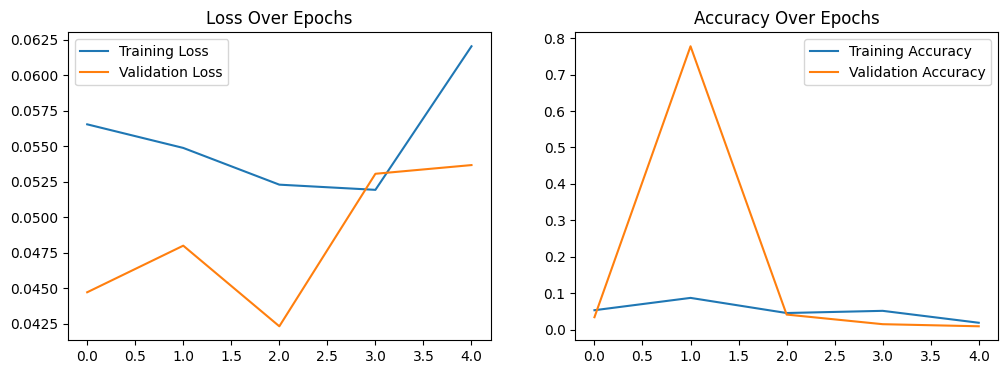

In [20]:
plot_training_history(history)

Извиняюсь что добрался до данного ДЗ только сейчас.

Курс в целом был очень интересен, узнал очень много нового, теперь есть понимание как и за что братся. Огромного спасибо Тимуры за проведенные семинары хоть я и смотрел их в записи.

Код не удалось запустить на ноутбуке, нехватило памяти, разворачивал на другом компьютере с 64гб оперативной памяти.
Всеравно оказалось что обучение занимает прям очень много времени (по расчету 7 суток при 512 фильтрах в слоях).
Поэтому пришлось установить 32 фильтра, чтобы хотябы показать работоспособность кода

В процессе написания добавил callback, также почитал много дополнительного материала.

После изучения появилось понимание как сделать дипломный проект, до обучение понимал только на половину. 